# Parameter covariance (or lack thereof) of PCA and KL decompositions

In [5]:
# Show plots inline, and load main getdist plot module and samples class
#Change
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
here = './' 
temp_path = os.path.realpath(os.path.join(os.getcwd(), here+'tensiometer'))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import gaussian_tension

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = here+'/tensiometer/test_chains/'
# the data chain:
settings = {'ignore_rows':0, 'smooth_scale_1D':0.3, 'smooth_scale_2D':0.3}
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=settings)
#chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True, settings=settings)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True, settings=settings)

In [7]:
# add useful parameters:
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(p.omegach2/(p.H0/100.)**2, name='omegac', label='\\Omega_c')
    ch.addDerived(p.omegabh2/(p.H0/100.)**2, name='omegab', label='\\Omega_b')
    ch.addDerived(p.sigma8*np.sqrt(p.omegam/0.3), name='S8', label='S_8')
    ch.addDerived(p.sigma8*5, name='sigma8_5', label='\\sigma_8 5')
    ch.addDerived(p.H0/100, name='h', label='h')
    # update after adding all parameters:
    ch.updateBaseStatistics()

In [10]:
# decide the parameters to use:
param_names = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']

In [12]:
# add log of the chosen parameters:
for ch in [chain, prior_chain]:
    for name in param_names:
        ch.addDerived(np.log(ch.samples[:, ch.index[name]]), name='log_'+name, label='\\log'+ch.getParamNames().parWithName(name).label)
    # update after adding all parameters:
    ch.updateBaseStatistics()

In [17]:
# now we generate the Gaussian approximation:
g_param_names = ['log_'+name for name in param_names]
n_samples = 100000
print(g_param_names)
# create the Gaussian:
gauss = gaussian_tension.gaussian_approximation(chain, param_names=g_param_names)
chain_gauss = gauss.MCSamples(size = n_samples)
prior_gauss = gaussian_tension.gaussian_approximation(prior_chain, param_names=g_param_names)
prior_chain_gauss = prior_gauss.MCSamples(size = n_samples)

['log_omegam', 'log_omegab', 'log_sigma8', 'log_ns', 'log_H0']


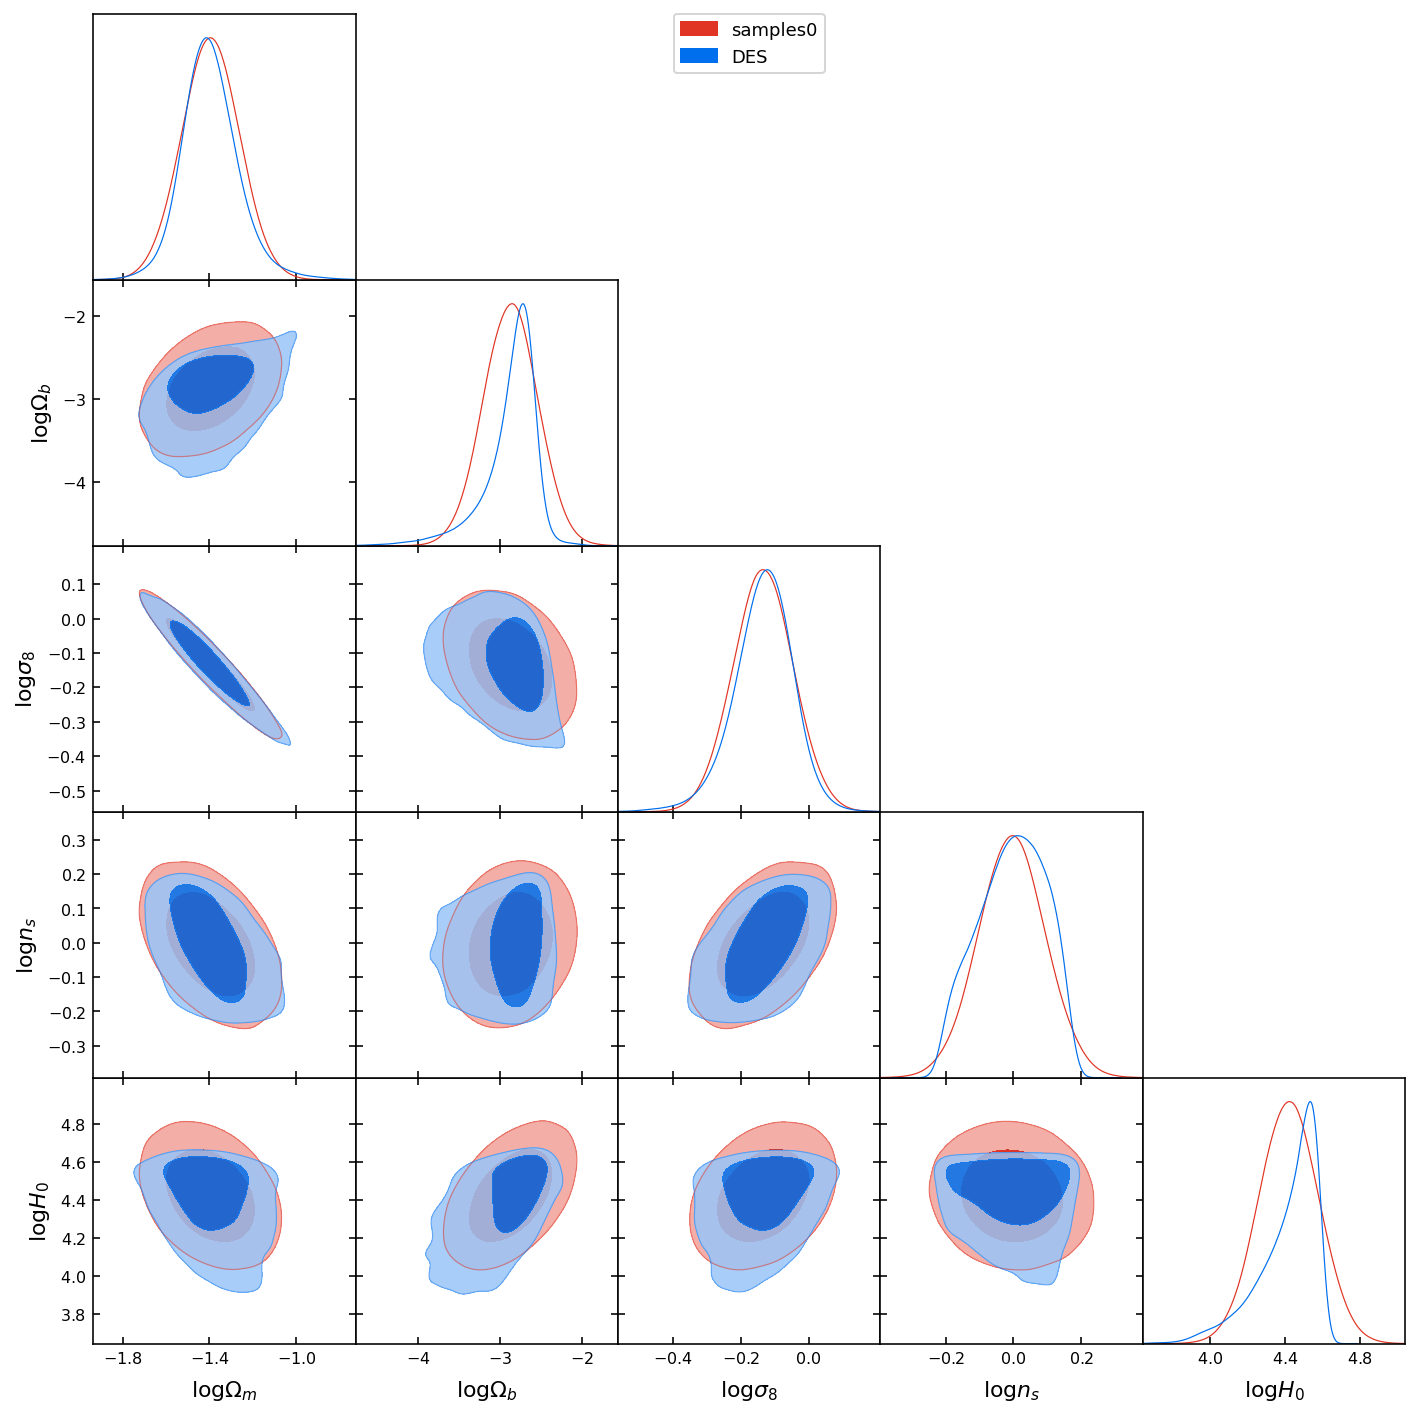

In [19]:
# look qualitatively at how the Gaussian approximation is doing:
g = plots.get_subplot_plotter()
g.triangle_plot([chain_gauss, chain], params=g_param_names, filled=True)

In [18]:
# after generating the two perfectly Gaussian chains we can compute here the other parameters as derived:
for ch in [chain_gauss, prior_chain_gauss]:
    p = ch.getParams()
    # the original parameters:
    for ind, name in enumerate(g_param_names):
        ch.addDerived(np.exp(ch.samples[:, ch.index[name]]), name=name.replace('log_',''), label=ch.getParamNames().parWithName(name).label.replace('\\log ',''))
    # 
    ch.updateBaseStatistics()

In [20]:
# define the parameter transformation:
A = np.array([[ 1, 0, 0, 0, 0],
              [-1, 1, 0, 0, 0],
              [ 0, 0, 1, 0, 0],
              [ 0, 0, 0, 1, 0],
              [ 0, 0, 0, 0, 1]])

In [22]:
# verify that it is not orthogonal:
np.linalg.inv(A)

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [38]:
covariance = chain.cov(pars=g_param_names)
# not using localization:
prior_covariance = prior_chain.cov(pars=g_param_names)
# using localization:
#prior_covariance = gaussian_tension.get_localized_covariance(prior_chain, chain, g_param_names)
tilde_covariance = np.dot(np.dot(A, covariance), A.T)
tilde_prior_covariance = np.dot(np.dot(A, prior_covariance), A.T)

In [39]:
# do PCA of the two covariances:
PCA_eig, PCA_eigv = np.linalg.eigh(covariance)
tilde_PCA_eig, tilde_PCA_eigv = np.linalg.eigh(tilde_covariance)

In [44]:
# do KL of the two covariances:
KL_eig, KL_eigv = utilities.KL_decomposition(prior_covariance, covariance)
tilde_KL_eig, tilde_KL_eigv = utilities.KL_decomposition(tilde_prior_covariance, tilde_covariance)

In [52]:
# transform the PCA modes in the original basis:
np.dot(A.T, tilde_PCA_eigv)

array([[ 0.56392258,  0.55014559,  0.29328244,  0.5776731 , -0.97959704],
       [-0.01579773, -0.2490096 , -0.20391422,  0.1956576 ,  0.92621906],
       [ 0.83596544, -0.21168514, -0.08418778, -0.4973318 ,  0.04387124],
       [-0.00370554,  0.74257808, -0.62836703, -0.20667842,  0.10489502],
       [ 0.02139232,  0.50107736,  0.74060759, -0.2713353 ,  0.35544535]])

In [53]:
PCA_eigv

array([[-0.59524505,  0.38720215,  0.24876089,  0.64273883, -0.14409245],
       [ 0.03835482, -0.22811979, -0.17660099,  0.02689988, -0.95633611],
       [-0.79852579, -0.37849481, -0.19383179, -0.41803733,  0.08229385],
       [-0.05178216,  0.66940161, -0.71780881, -0.18109284, -0.03429284],
       [-0.06234913,  0.45461964,  0.59507131, -0.61531566, -0.23813931]])

In [50]:
# transform the KL modes in the original basis:
np.dot(A.T, tilde_KL_eigv)

array([[-9.13694633e-01,  2.77208654e-02, -4.16580585e+00,
         8.18851877e+00, -2.69746054e+01],
       [-8.26468874e-01, -6.14885019e-01,  5.24738782e+00,
        -4.31836505e+00,  2.03393841e+00],
       [ 9.80553814e-01, -5.31490726e-02,  4.07945657e+00,
        -1.28323466e+01, -3.41205034e+01],
       [ 2.46197871e+00, -9.18117554e+00, -8.82772707e+00,
         1.39658833e+01, -3.33507225e+00],
       [-4.93651998e+00, -1.39897291e+00, -9.70950611e+00,
         8.03272885e+00, -3.36746035e+00]])

In [51]:
KL_eigv

array([[-9.13694633e-01, -2.77208654e-02, -4.16580585e+00,
         8.18851877e+00,  2.69746054e+01],
       [-8.26468874e-01,  6.14885019e-01,  5.24738782e+00,
        -4.31836505e+00, -2.03393841e+00],
       [ 9.80553814e-01,  5.31490726e-02,  4.07945657e+00,
        -1.28323466e+01,  3.41205034e+01],
       [ 2.46197871e+00,  9.18117554e+00, -8.82772707e+00,
         1.39658833e+01,  3.33507225e+00],
       [-4.93651998e+00,  1.39897291e+00, -9.70950611e+00,
         8.03272885e+00,  3.36746035e+00]])

# Running with Gaussian chains

In [66]:
param_names_gauss = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']
print(param_names_gauss)
KL_param_names_gauss = ['log_'+name for name in param_names_gauss]
print(KL_param_names_gauss)
# compute the KL modes:
KL_eig, KL_eigv, KL_param_names_gauss = gaussian_tension.Q_UDM_KL_components(prior_chain_gauss, chain_gauss, param_names=KL_param_names_gauss)
# print:
with np.printoptions(precision=2, suppress=True):
    print('Improvement factor over the prior:', KL_eig)
    print('Improvement in error units:', np.sqrt(KL_eig-1))
    
# do the PCA on the log parameters:
#print(chain)

PCA_param_names = ['log_'+name for name in param_names_gauss]
# compute the PCA modes:
#PCA_eig, PCA_eigv, PCA_param_names = 
#PCA_out = chain_gauss.PCA(KL_param_names)
#print(PCA_out)

# print:
#with np.printoptions(precision=2, suppress=True):
#    print('Improvement factor over the prior:', PCA_eig)
#    print('Improvement in error units:', np.sqrt(PCA_eig-1))


['omegam', 'omegab', 'sigma8', 'ns', 'H0']
['log_omegam', 'log_omegab', 'log_sigma8', 'log_ns', 'log_H0']
Improvement factor over the prior: [1415.99   51.22   31.55    1.34    1.12]
Improvement in error units: [37.62  7.09  5.53  0.59  0.35]


In [67]:
PCA_eig, PCA_eigv = np.linalg.eigh(chain_gauss.cov(KL_param_names_gauss))
print(PCA_eig)

[0.00052009 0.00133478 0.0155105  0.03394184 0.12121204]


In [ ]:
# First we compute the fractional Fisher matrix:
KL_param_names, KL_eig, fractional_fisher, _ = gaussian_tension.Q_UDM_fisher_components(prior_chain, chain, KL_param_names, which='1')
# plot (showing values and names):
im1 = plt.imshow( fractional_fisher, cmap='viridis')
num_params = len(fractional_fisher)
for i in range(num_params):
    for j in range(num_params):
        if fractional_fisher[j,i]>0.5:
            col = 'k'
        else:
            col = 'w'
        plt.text(i, j, np.round(fractional_fisher[j,i],2), va='center', ha='center', color=col)
plt.xlabel('KL mode (error improvement)');
plt.ylabel('Parameters');
ticks  = np.arange(num_params)
labels = [ str(t+1)+'\n ('+str(l)+')' for t,l in zip(ticks,np.round(np.sqrt(KL_eig-1.),2))]
plt.xticks(ticks, labels, horizontalalignment='center');
labels = [ '$'+chain.getParamNames().parWithName(name).label+'$' for name in KL_param_names ]
plt.yticks(ticks, labels, horizontalalignment='right');

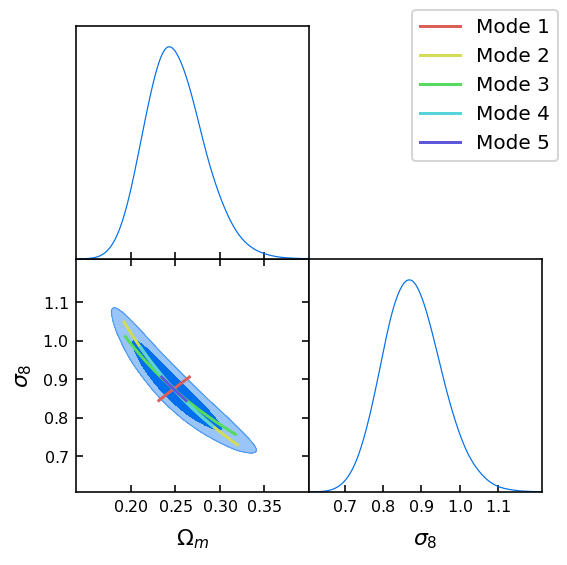

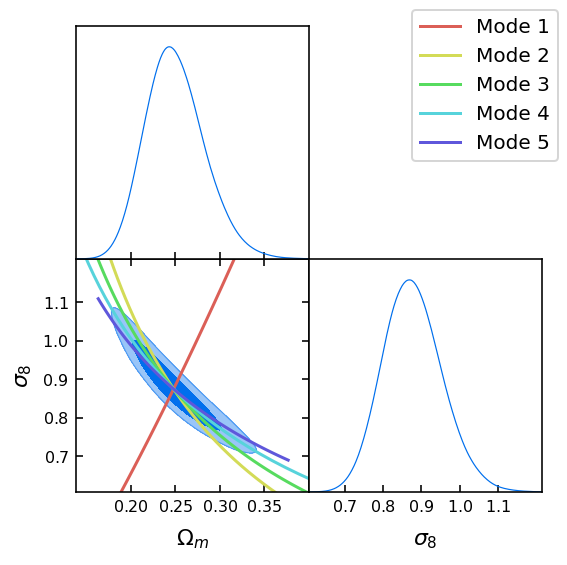

In [94]:
for eigv,title in zip([KL_eigv, PCA_eigv], ['KL','PCA']):
    param_names_plot = ['omegam','sigma8']
    KL_param_names_plot = ['log_'+name for name in param_names_plot]

    param_directions = np.linalg.inv(eigv.T)
    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_gauss], params=param_names_plot, filled=True)
    # add the modes:
    for i in range(len(param_names_plot)-1):
        for j in range(i+1,len(param_names_plot)):
            ax = g.subplots[j,i]\
            # get mean:
            m1, m2 = chain_gauss.getMeans(pars=[chain_gauss.index[name]
                           for name in [KL_param_names_plot[i], KL_param_names_plot[j]]])
            #ax.scatter(np.exp(m1), np.exp(m2), color='k')
            alpha = 3.*np.linspace(-1.,1.,100)
            list_ind = [chain_gauss.index[name]
                           for name in [KL_param_names_plot[i], KL_param_names_plot[j]]]
            i1 = list_ind[0]
            j1 = list_ind[1]
            for k in range(5):

                ax.plot(np.exp(m1+alpha*param_directions[:,k][i1]), np.exp(m2+alpha*param_directions[:,k][j1]), color=sns.hls_palette(6)[k], label='Mode '+str(k+1))
    g.fig.legend(*ax.get_legend_handles_labels())
    
    
    
    